# Data Processing Workflow

In [ ]:
import pandas as pd 
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Set
from collections import defaultdict
from Bio import Align
from Bio.Seq import Seq
from tqdm import tqdm
import os
import subprocess
import time
from pathlib import Path
from typing import List, Optional

In [ ]:
train_path = "train.txt" 
test_path = "test.txt"
eval_path = "eval.txt"

In [24]:
df_train = pd.read_csv(train_path, sep=" ", header=None)
df_train.columns = ["AA_Sequence"]

In [25]:
df_test = pd.read_csv(test_path, sep=" ", header=None)
df_test.columns = ["AA_Sequence"]

In [26]:
df_eval = pd.read_csv(eval_path, sep=" ", header=None)
df_eval.columns = ["AA_Sequence"]

In [27]:
# Concatenate DataFrames vertically
df_agg = pd.concat([df_train, df_test, df_eval], ignore_index=True)

df_agg.head()

,AA_Sequence
0,EVQLVESGGVVVQPGGSLRLSCAASGFTFDDYTMHWVRQAPGKGLE...
1,QVQLQESGPGLVKPSETLSLTCTVSGGSISTYYWSWIRQPPGKGLE...
2,QVQLQESGPGLVKPSETLSLTCSVSGGSLSNNTYYWAWIRQPPGKG...
3,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYMHWVRQAPGQGLE...
4,QVQLVESGGGVVQPGRSLRLSCAASGFTFSDYAMHWVRQAPGKGLN...


In [28]:
# Variable chain heavy and light chain sequences
df_agg['AA_Sequence'][0]

'EVQLVESGGVVVQPGGSLRLSCAASGFTFDDYTMHWVRQAPGKGLEWVSLISWDGGSTYYADSVKGRFTISRDNSKNSLYLQMNSLRTEDTALYYCAKDKSGYHAGYFDYWGQGTLVTVSS</s>DIQMTQSPSSLSASVGDRVTITCRASQGISNYLAWFQQKPGKAPKSLIYAASSLQSGVPSKFSGSGSGTDFTLTISSLQPEDFATYYCQQYNSYPLTFGGGTKVEIK'

### Get 15% data for word2vec model

In [27]:
# Determine the split point (half of the DataFrame's length)
split_point = math.floor(len(df_agg)*0.15)

# Split the DataFrame into two equal parts
w2v_data = df_agg.iloc[:split_point].reset_index(drop=True)
df_new_agg = df_agg.iloc[split_point:].reset_index(drop=True)

In [28]:
# Split the sequence and append to new column
new_w2v_data = w2v_data['AA_Sequence'].str.split('</s>')
# Explode the lists into separate rows
new_w2v_data = new_w2v_data.explode().reset_index(drop=True)

In [29]:
new_w2v_data.head()

0    EVQLVESGGVVVQPGGSLRLSCAASGFTFDDYTMHWVRQAPGKGLE...
1    DIQMTQSPSSLSASVGDRVTITCRASQGISNYLAWFQQKPGKAPKS...
2    QVQLQESGPGLVKPSETLSLTCTVSGGSISTYYWSWIRQPPGKGLE...
3    EIVLTQSPGTLSLSPGERATLSCRASQSVSNNYLAWYQQKPGQAPR...
4    QVQLQESGPGLVKPSETLSLTCSVSGGSLSNNTYYWAWIRQPPGKG...
Name: AA_Sequence, dtype: object

In [30]:
new_w2v_data.info()

<class 'pandas.core.series.Series'>
RangeIndex: 400756 entries, 0 to 400755
Series name: AA_Sequence
Non-Null Count   Dtype 
--------------   ----- 
400756 non-null  object
dtypes: object(1)
memory usage: 3.1+ MB


In [31]:
df_new_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135476 entries, 0 to 1135475
Data columns (total 1 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   AA_Sequence  1135476 non-null  object
dtypes: object(1)
memory usage: 8.7+ MB


### Separate heavy and light chain sequences

In [32]:
# Split the sequence column into two new columns: Heavy Chain and Light Chain
df_new_agg[['heavy_chain', 'light_chain']] = df_new_agg['AA_Sequence'].str.split('</s>', expand=True)

### Save sequences to CSV for latent negative sample generation

In [33]:
# Define percentage of indices to filter out 
percentage = 15 

# Calculate number of rows to select
num_to_select = int(len(df_new_agg) * (percentage / 100))

# Randomly select indices
random_indices = np.random.choice(df_new_agg.index, num_to_select, replace=False)

# 1. Extract the selected rows from df_new_agg
selected_sequences = df_new_agg.loc[random_indices]

# Filter out the selected rows
df_left = df_new_agg.drop(index=random_indices)

selected_sequences.to_csv('vae_sequences.csv', index=False)

In [ ]:
# Read the VAE sequences that were filtered out
vae_sequences = pd.read_csv('vae_sequences.csv')

# Get df_left by removing the vae_sequences rows from df_new_agg
df_left = df_new_agg[~df_new_agg['AA_Sequence'].isin(vae_sequences['AA_Sequence'])]

# Verify the sizes
print(f"Original df_new_agg size: {len(df_new_agg)}")
print(f"vae_sequences size: {len(vae_sequences)}")
print(f"Resulting df_left size: {len(df_left)}")

# Verify that the sum of lengths is correct
assert len(df_left) + len(vae_sequences) == len(df_new_agg), "Size mismatch in reconstruction"

Original df_new_agg size: 1135476
vae_sequences size: 170321
Resulting df_left size: 965155


In [ ]:
# Save data remaining
df_left.to_csv('df_left.csv', index=False)
# df_left = pd.read_csv('df_left.csv')

In [ ]:
# Save w2v training data
new_w2v_data.to_csv('w2v_data.csv', index=False)

### Split the data into paired and unpaired

In [ ]:
def shuffle_without_replacement(series):
    """
    Shuffle a series ensuring no element remains in its original position.
    
    Args:
        series: pandas Series to shuffle
        
    Returns:
        Shuffled series with no element in its original position
    """
    n = len(series)
    indices = np.arange(n)
    shuffled_indices = indices.copy()
    
    max_attempts = 100
    attempt = 0
    
    while attempt < max_attempts:
        np.random.shuffle(shuffled_indices)
        if not any(shuffled_indices[i] == i for i in range(n)):
            break
        attempt += 1
    
    # Fix remaining matches if cannot find a perfect shuffle
    for i in range(n):
        if shuffled_indices[i] == i:
            # Find position not matching and swap
            for j in range(n):
                if shuffled_indices[j] != j and shuffled_indices[j] != i:
                    shuffled_indices[i], shuffled_indices[j] = shuffled_indices[j], shuffled_indices[i]
                    break
                    
    return series.iloc[shuffled_indices].reset_index(drop=True)

In [ ]:
class ProteinShuffler:
    def __init__(self, similarity_threshold: float = 0.20):
        from Bio.Align import substitution_matrices

        self.blosum62 = substitution_matrices.load('BLOSUM62')
        self.similarity_threshold = similarity_threshold
        
    def _get_blosum62_score(self, a: str, b: str) -> float:
        pair = (a, b) if (a, b) in self.blosum62 else (b, a)
        return self.blosum62.get(pair, -4)
        
    def compute_sequence_similarity(self, seq1: List[str], seq2: List[str]) -> float:
        """
        Compute sequence similarity considering length differences.
        Returns normalized similarity score between 0-1.
        """
        # Different lengths contribute to dissimilarity
        length_similarity = min(len(seq1), len(seq2)) / max(len(seq1), len(seq2))
        
        # Compare overlapping regions using BLOSUM62
        min_length = min(len(seq1), len(seq2))
        max_score = sum(self._get_blosum62_score(a, a) for a in seq1[:min_length])
        alignment_score = sum(self._get_blosum62_score(a, b) 
                            for a, b in zip(seq1[:min_length], seq2[:min_length]))
        
        sequence_similarity = (alignment_score / max_score) if max_score != 0 else 0
        
        # Combine length and sequence similarity
        total_similarity = length_similarity * sequence_similarity
        return max(0.0, min(1.0, total_similarity))
        
    def shuffle_sequence(
        self,
        sequence: pd.Series,
        max_attempts: int = 1000,
        random_state: Optional[int] = None
    ) -> pd.Series:
        if random_state is not None:
            np.random.seed(random_state)
            
        n = len(sequence)
        if n <= 1:
            return sequence.copy()
            
        original_seq = sequence.tolist()
        best_indices = None
        lowest_similarity = float('inf')
        attempts = 0
        
        while attempts < max_attempts:
            attempts += 1
            indices = np.arange(n)
            np.random.shuffle(indices)
            
            candidate_seq = sequence.iloc[indices].tolist()
            similarity = self.compute_sequence_similarity(
                original_seq, candidate_seq)
            
            if similarity < self.similarity_threshold and similarity < lowest_similarity:
                lowest_similarity = similarity
                best_indices = indices.copy()
                
                if similarity < self.similarity_threshold / 2:
                    break
        
        if best_indices is None:
            raise ValueError(
                f"Could not find sufficiently dissimilar shuffle after {max_attempts} "
                f"attempts. Best similarity achieved: {lowest_similarity:.2%}"
            )
        
        return sequence.iloc[best_indices].reset_index(drop=True)

    def get_similarity_stats(self, original: pd.Series, shuffled: pd.Series) -> dict:
        orig_seq = original.tolist()
        shuf_seq = shuffled.tolist()
        
        similarity = self.compute_sequence_similarity(orig_seq, shuf_seq)
        position_scores = [
            self._get_blosum62_score(a, b) 
            for a, b in zip(orig_seq, shuf_seq)
        ]
        
        return {
            'overall_similarity': similarity,
            'average_blosum62_score': np.mean(position_scores),
            'max_blosum62_score': max(position_scores),
            'min_blosum62_score': min(position_scores)
        }

In [6]:
class AntibodyPairSampler:
    def __init__(self, df: pd.DataFrame, similarity_threshold: float = 0.20):
        self.df = df
        self.similarity_threshold = similarity_threshold
        self.shuffler = ProteinShuffler(similarity_threshold=similarity_threshold)
        self.heavy_motifs = self._extract_motifs(df['heavy_chain'])
        self.light_motifs = self._extract_motifs(df['light_chain'])
        
    def _extract_motifs(self, sequences: pd.Series, k: int = 3) -> Dict[str, List[int]]:
        motif_positions = {}
        for idx, seq in enumerate(sequences):
            for i in range(len(seq) - k + 1):
                motif = seq[i:i+k]
                if motif not in motif_positions:
                    motif_positions[motif] = []
                motif_positions[motif].append(idx)
        return motif_positions
    
    def _get_motif_candidates(self, sequence: str, motif_dict: Dict[str, List[int]], k: int = 3) -> Set[int]:
        candidates = set()
        for i in range(len(sequence) - k + 1):
            motif = sequence[i:i+k]
            if motif in motif_dict:
                candidates.update(motif_dict[motif])
        return candidates
    
    def generate_negative_pairs(self, n_pairs: int, max_attempts_per_pair: int = 50, balanced=True) -> pd.DataFrame:
        negative_pairs = []
        preserved_pairs = []
        similarity_stats = []
        
        # Number of pairs to generate with each approach
        heavy_based_pairs = n_pairs // 2 if balanced else n_pairs
        light_based_pairs = n_pairs - heavy_based_pairs if balanced else 0
        
        # Track progress
        if balanced:
            print(f"Generating {heavy_based_pairs} heavy-based pairs and {light_based_pairs} light-based pairs")
        
        # Generate heavy-based pairs 
        heavy_count = 0
        while heavy_count < heavy_based_pairs:
            if len(negative_pairs) + len(preserved_pairs) >= n_pairs:
                break
                
            heavy_idx = np.random.randint(len(self.df))
            heavy_seq = list(self.df.iloc[heavy_idx]['heavy_chain'])
            
            heavy_candidates = self._get_motif_candidates(
                self.df.iloc[heavy_idx]['heavy_chain'], 
                self.heavy_motifs
            )
            
            found_dissimilar = False
            attempts = 0
            
            while attempts < max_attempts_per_pair and not found_dissimilar:
                if not heavy_candidates:
                    break
                    
                candidate_idx = np.random.choice(list(heavy_candidates))
                light_seq = list(self.df.iloc[candidate_idx]['light_chain'])
                
                similarity = self.shuffler.compute_sequence_similarity(
                    heavy_seq, 
                    light_seq
                )
                
                if similarity < self.similarity_threshold:
                    pair_data = {
                        'heavy_chain': ''.join(heavy_seq),
                        'light_chain': ''.join(light_seq),
                        'similarity': similarity,
                        'preserved': False
                    }
                    negative_pairs.append(pair_data)
                    similarity_stats.append(similarity)
                    found_dissimilar = True
                    heavy_count += 1
                else:
                    heavy_candidates.remove(candidate_idx)
                
                attempts += 1
            
            if not found_dissimilar:
                original_pair = self.df.iloc[heavy_idx]
                orig_heavy = list(original_pair['heavy_chain'])
                orig_light = list(original_pair['light_chain'])
                
                similarity = self.shuffler.compute_sequence_similarity(
                    orig_heavy,
                    orig_light
                )
                
                pair_data = {
                    'heavy_chain': original_pair['heavy_chain'],
                    'light_chain': original_pair['light_chain'],
                    'similarity': similarity,
                    'preserved': True
                }
                preserved_pairs.append(pair_data)
                similarity_stats.append(similarity)
        
        # Generate light-based pairs 
        if balanced:
            light_count = 0
            while light_count < light_based_pairs:
                if len(negative_pairs) + len(preserved_pairs) >= n_pairs:
                    break
                    
                light_idx = np.random.randint(len(self.df))
                light_seq = list(self.df.iloc[light_idx]['light_chain'])
                
                light_candidates = self._get_motif_candidates(
                    self.df.iloc[light_idx]['light_chain'], 
                    self.light_motifs
                )
                
                found_dissimilar = False
                attempts = 0
                
                while attempts < max_attempts_per_pair and not found_dissimilar:
                    if not light_candidates:
                        break
                        
                    candidate_idx = np.random.choice(list(light_candidates))
                    heavy_seq = list(self.df.iloc[candidate_idx]['heavy_chain'])
                    
                    similarity = self.shuffler.compute_sequence_similarity(
                        heavy_seq, 
                        light_seq
                    )
                    
                    if similarity < self.similarity_threshold:
                        pair_data = {
                            'heavy_chain': ''.join(heavy_seq),
                            'light_chain': ''.join(light_seq),
                            'similarity': similarity,
                            'preserved': False
                        }
                        negative_pairs.append(pair_data)
                        similarity_stats.append(similarity)
                        found_dissimilar = True
                        light_count += 1
                    else:
                        light_candidates.remove(candidate_idx)
                    
                    attempts += 1
                
                if not found_dissimilar and light_count < light_based_pairs:
                    original_pair = self.df.iloc[light_idx]
                    orig_heavy = list(original_pair['heavy_chain'])
                    orig_light = list(original_pair['light_chain'])
                    
                    similarity = self.shuffler.compute_sequence_similarity(
                        orig_heavy,
                        orig_light
                    )
                    
                    pair_data = {
                        'heavy_chain': original_pair['heavy_chain'],
                        'light_chain': original_pair['light_chain'],
                        'similarity': similarity,
                        'preserved': True
                    }
                    preserved_pairs.append(pair_data)
                    similarity_stats.append(similarity)
        
        all_pairs = negative_pairs + preserved_pairs
        result_df = pd.DataFrame(all_pairs)
        
        print(f"\nMotif generation stats:")
        print(f"Generated {len(negative_pairs):,} dissimilar pairs")
        if balanced:
            print(f"  - Heavy-based: {heavy_count:,}")
            print(f"  - Light-based: {light_count:,}")
        print(f"Preserved {len(preserved_pairs):,} original pairs")
        if similarity_stats:
            print(f"Mean similarity: {np.mean(similarity_stats):.2%}")
            print(f"Max similarity: {max(similarity_stats):.2%}")
        
        return result_df[['heavy_chain', 'light_chain']]

In [7]:
def create_enhanced_negatives(
    df_filtered: pd.DataFrame,
    strategies: Dict[str, float] = None,
    batch_size: int = 1000,
    similarity_threshold: float = 0.20,
    random_state: Optional[int] = None,
    balanced_motif: bool = False  # Added parameter with default False for backward compatibility
) -> pd.DataFrame:
    """
    Generate negative pairs using multiple strategies:
    1. Dissimilarity-based shuffling (using BLOSUM62)
    2. Random shuffling (ensuring no position matches)
    3. Motif-based pairing (can be balanced to use both heavy and light chains)
    
    Args:
        df_filtered: DataFrame with 'heavy_chain' and 'light_chain' columns
        strategies: Dict of strategy names and their proportions
        batch_size: Number of pairs to generate in each batch
        similarity_threshold: Maximum allowed similarity for dissimilar pairs
        random_state: Random seed for reproducibility
        balanced_motif: If True, use both heavy and light chains for motif-based generation
        
    Returns:
        DataFrame with generated pairs and their strategy labels
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    start_time = time.time()
    
    if strategies is None:
        strategies = {
            'dissimilar_shuffle': 0.3,  # Dissimilarity-based shuffling
            'random_shuffle': 0.3,      # Pure random shuffling
            'motif': 0.4                # Motif-based pairing
        }
    
    shuffler = ProteinShuffler(similarity_threshold=similarity_threshold)
    
    n_positives = len(df_filtered)
    print(f"Total positives: {n_positives}")
    print("\nStep 1: Selecting positive pairs...")
    
    n_keep_positives = n_positives // 2
    positive_df = df_filtered.sample(n=n_keep_positives, random_state=random_state)
    positive_df['paired'] = 1
    positive_df['strategy'] = 'positive'
    print(f"Selected {n_keep_positives:,} positive pairs")
    
    print("\nStep 2: Identifying unique chains...")
    positive_heavy_chains = set(positive_df['heavy_chain'])
    positive_light_chains = set(positive_df['light_chain'])
    print(f"Unique heavy chains in positives: {len(positive_heavy_chains):,}")
    print(f"Unique light chains in positives: {len(positive_light_chains):,}")
    
    print("\nStep 3: Filtering remaining data...")
    remaining_df = df_filtered[
        (~df_filtered['heavy_chain'].isin(positive_heavy_chains)) & 
        (~df_filtered['light_chain'].isin(positive_light_chains))
    ].reset_index(drop=True)
    
    print(f"Chains available for negatives: {len(remaining_df):,}")
    
    # Calculate target numbers for each strategy
    n_dissimilar = int(n_keep_positives * strategies.get('dissimilar_shuffle', 0))
    n_random = int(n_keep_positives * strategies.get('random_shuffle', 0))
    n_motif = int(n_keep_positives * strategies.get('motif', 0))
    
    print(f"\nTarget numbers:")
    print(f"Dissimilar shuffled negatives: {n_dissimilar:,}")
    print(f"Random shuffled negatives: {n_random:,}")
    print(f"Motif negatives: {n_motif:,}")
    
    # Generate dissimilarity-based shuffled pairs
    print("\nStep 4: Generating dissimilarity-based shuffled negatives...")
    dissimilar_start = time.time()
    
    dissimilar_pairs = []
    preserved_pairs = []
    similarity_stats = []
    
    if n_dissimilar > 0:
        dissimilar_df = remaining_df.head(n_dissimilar)
        print(f"Processing {len(dissimilar_df):,} pairs for dissimilar shuffling")
        
        for idx, row in dissimilar_df.iterrows():
            try:
                light_seq = pd.Series(list(row['light_chain']))
                shuffled_seq = shuffler.shuffle_sequence(light_seq)
                
                dissimilar_pairs.append({
                    'heavy_chain': row['heavy_chain'],
                    'light_chain': ''.join(shuffled_seq),
                    'strategy': 'dissimilar_shuffle'
                })
                
                stats = shuffler.get_similarity_stats(
                    pd.Series(list(row['light_chain'])), 
                    shuffled_seq
                )
                similarity_stats.append(stats['overall_similarity'])
                
            except ValueError:
                preserved_pairs.append({**row, 'strategy': 'preserved'})
    
    if dissimilar_pairs:
        dissimilar_df = pd.DataFrame(dissimilar_pairs)
        print(f"Generated {len(dissimilar_df):,} dissimilar shuffled pairs")
        print(f"Mean similarity: {np.mean(similarity_stats):.2%}")
        print(f"Max similarity: {max(similarity_stats):.2%}")
    else:
        dissimilar_df = pd.DataFrame(columns=['heavy_chain', 'light_chain', 'strategy'])
    
    # Generate random shuffled pairs
    print("\nStep 5: Generating random shuffled negatives...")
    random_start = time.time()
    
    random_pairs = []
    if n_random > 0:
        random_df = remaining_df.iloc[n_dissimilar:n_dissimilar + n_random]
        print(f"Processing {len(random_df):,} pairs for random shuffling")
        
        for idx, row in random_df.iterrows():
            light_seq = pd.Series(list(row['light_chain']))
            shuffled_seq = shuffle_without_replacement(light_seq)
            
            random_pairs.append({
                'heavy_chain': row['heavy_chain'],
                'light_chain': ''.join(shuffled_seq),
                'strategy': 'random_shuffle'
            })
    
    random_df = pd.DataFrame(random_pairs)
    print(f"Generated {len(random_df):,} random shuffled pairs")
    
    # Generate motif-based pairs
    print("\nStep 6: Generating motif-based negatives...")
    if balanced_motif:
        print("Using balanced motif generation with both heavy and light chains")
    print(f"Processing in batches of {batch_size:,}")
    motif_start = time.time()
    
    motif_df = pd.DataFrame()
    if n_motif > 0:
        sampler = AntibodyPairSampler(remaining_df.iloc[n_dissimilar + n_random:], 
                                     similarity_threshold=similarity_threshold)
        motif_df = sampler.generate_negative_pairs(n_motif, balanced=balanced_motif)
        motif_df['strategy'] = 'motif'
    
    # Combine all negative pairs
    print("\nStep 7: Combining datasets...")
    negative_df = pd.concat([
        dissimilar_df,
        random_df,
        motif_df,
        pd.DataFrame(preserved_pairs)
    ]).reset_index(drop=True)
    
    negative_df['paired'] = 0
    final_df = pd.concat([positive_df, negative_df]).reset_index(drop=True)
    
    print("\nFinal dataset composition:")
    print(f"Total samples: {len(final_df):,}")
    print(f"Positives: {len(positive_df):,} ({len(positive_df)/len(final_df)*100:.1f}%)")
    
    for strategy in ['dissimilar_shuffle', 'random_shuffle', 'motif', 'preserved']:
        strategy_count = len(final_df[final_df['strategy'] == strategy])
        if strategy_count > 0:
            print(f"{strategy.title()}: {strategy_count:,} ({strategy_count/len(final_df)*100:.1f}%)")
    
    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
    
    return final_df

In [10]:
strategies = {
    'dissimilar_shuffle': 0.3,  # % using dissimilarity-based shuffling
    'random_shuffle': 0,      # % using random shuffling
    'motif': 0.2              # % using motif-based pairing
}

final_df = create_enhanced_negatives(
    df_left,
    strategies=strategies,
    batch_size=1000,
    similarity_threshold=0.20,
    random_state=42
)

Total positives: 965155

Step 1: Selecting positive pairs...
Selected 482,577 positive pairs

Step 2: Identifying unique chains...
Unique heavy chains in positives: 481,602
Unique light chains in positives: 198,051

Step 3: Filtering remaining data...
Chains available for negatives: 178,747

Target numbers:
Dissimilar shuffled negatives: 144,773
Random shuffled negatives: 0
Motif negatives: 96,515

Step 4: Generating dissimilarity-based shuffled negatives...
Processing 144,773 pairs for dissimilar shuffling
Generated 144,773 dissimilar shuffled pairs
Mean similarity: 0.00%
Max similarity: 3.73%

Step 5: Generating random shuffled negatives...
Generated 0 random shuffled pairs

Step 6: Generating motif-based negatives...
Processing in batches of 1,000

Motif generation stats:
Generated 96,515 dissimilar pairs
Preserved 0 original pairs
Mean similarity: 0.04%
Max similarity: 14.48%

Step 7: Combining datasets...

Final dataset composition:
Total samples: 723,865
Positives: 482,577 (66.7%

In [11]:
# no need combine if read from csv
def combine_chains(row):
    """Combine heavy and light chains with '...' separator"""
    return f"{row['heavy_chain']}</s>{row['light_chain']}"

# Fill NaN values in AA_Sequence with combined chains
final_df.loc[final_df['AA_Sequence'].isna(), 'AA_Sequence'] = \
    final_df[final_df['AA_Sequence'].isna()].apply(combine_chains, axis=1)

In [ ]:
# Save dataset
final_df.to_csv('final_dataset_dis_mot_new.csv', index=False)
# final_df = pd.read_csv('final_dataset_dis_mot_new.csv')

In [3]:
final_df.head()

,AA_Sequence,heavy_chain,light_chain,paired,strategy
0,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYDINWVRQATGQGLE...,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYDINWVRQATGQGLE...,DIQMTQSPSSLSASVGDRVTITCRASQGISNYLAWYQQKPGKVPKL...,1,positive
1,QVQLQESGPGLVKPSETLSLTCTVSGGSISNYYWSWIRQPPGERLE...,QVQLQESGPGLVKPSETLSLTCTVSGGSISNYYWSWIRQPPGERLE...,EIVLTQSPGTLSLSPGERATLSCRASQSVRNNYLAWYQRKPGQAPR...,1,positive
2,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,NFMLTQPHSVSESPGKTVTISCTRSSGSIASNYVQWYQQRPGSAPT...,1,positive
3,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,DIQMTQSPSSLSASVGDRVTITCQASQDISNYLNWYQQKPGKAPKL...,1,positive
4,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...,QSALTQPRSVSGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAP...,1,positive


In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723865 entries, 0 to 723864
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   AA_Sequence  723865 non-null  object
 1   heavy_chain  723865 non-null  object
 2   light_chain  723865 non-null  object
 3   paired       723865 non-null  int64 
 4   strategy     723865 non-null  object
dtypes: int64(1), object(4)
memory usage: 27.6+ MB


### Adding negative sequences from VAE

In [ ]:
# Load the negative pairs"
neg_pairs = pd.read_csv(r"paired_negatives_20250208_030800.csv")

# Create binary 'paired' column for neg_pairs 
neg_pairs['paired'] = 0  # All negative pairs get 0

# Select only the columns we need from neg_pairs to match final_df
neg_pairs_filtered = neg_pairs[['AA_Sequence', 'heavy_chain', 'light_chain', 'paired']]

# Concatenate final_df with neg_pairs_filtered
df_combined = pd.concat([final_df, neg_pairs_filtered], ignore_index=True)

print(f"Number of sequences in final_df: {len(final_df)}")
print(f"Number of sequences in neg_pairs: {len(neg_pairs)}")
print(f"Total sequences after concatenation: {len(df_combined)}")
print(f"\nVerification of paired column:")
print(df_combined['paired'].value_counts())

# Check for duplicate sequences
duplicate_count = df_combined['AA_Sequence'].duplicated().sum()
print(f"\nNumber of duplicate sequences: {duplicate_count}")

# Remove duplicates if needed
df_combined = df_combined.drop_duplicates(subset=['AA_Sequence'], keep='first')
print(f"Final number of sequences after removing duplicates: {len(df_combined)}")

Number of sequences in final_df: 723865
Number of sequences in neg_pairs: 75000
Total sequences after concatenation: 798865

Verification of paired column:
paired
1    482577
0    316288
Name: count, dtype: int64

Number of duplicate sequences: 3
Final number of sequences after removing duplicates: 798862


In [6]:
df_combined.head()

,AA_Sequence,heavy_chain,light_chain,paired,strategy
0,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYDINWVRQATGQGLE...,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYDINWVRQATGQGLE...,DIQMTQSPSSLSASVGDRVTITCRASQGISNYLAWYQQKPGKVPKL...,1,positive
1,QVQLQESGPGLVKPSETLSLTCTVSGGSISNYYWSWIRQPPGERLE...,QVQLQESGPGLVKPSETLSLTCTVSGGSISNYYWSWIRQPPGERLE...,EIVLTQSPGTLSLSPGERATLSCRASQSVRNNYLAWYQRKPGQAPR...,1,positive
2,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,NFMLTQPHSVSESPGKTVTISCTRSSGSIASNYVQWYQQRPGSAPT...,1,positive
3,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,DIQMTQSPSSLSASVGDRVTITCQASQDISNYLNWYQQKPGKAPKL...,1,positive
4,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...,QSALTQPRSVSGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAP...,1,positive


In [ ]:
# Save VAE + previously generated data
df_combined.to_csv('df_combined_new.csv', index=False)
# df_combined = pd.read_csv('df_combined.csv')

In [9]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798862 entries, 0 to 798864
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   AA_Sequence  798862 non-null  object
 1   heavy_chain  798862 non-null  object
 2   light_chain  798862 non-null  object
 3   paired       798862 non-null  int64 
 4   strategy     723863 non-null  object
dtypes: int64(1), object(4)
memory usage: 36.6+ MB


### Using CD-HIT to remove similar sequences


In [10]:
def check_cdhit_installation():
    try:
        subprocess.run(['cd-hit', '-h'], 
                      capture_output=True, 
                      text=True)
        print("CD-HIT is installed and accessible")
        return True
    except FileNotFoundError:
        print("CD-HIT not found. Please install using:")
        print("conda install -c bioconda cd-hit")
        return False

In [11]:
check_cdhit_installation()

CD-HIT is installed and accessible


True

In [12]:
import os
import time
import subprocess
from tqdm import tqdm
import pandas as pd
from pathlib import Path

def get_size_range(size):
    """Helper function to categorize cluster sizes"""
    if size == 1:
        return "1-1"
    elif size <= 5:
        return "2-5"
    elif size <= 10:
        return "6-10"
    elif size <= 20:
        return "11-20"
    elif size <= 50:
        return "21-50"
    elif size <= 100:
        return "51-100"
    else:
        return "101+"

def parse_cluster_line(line):
    """Parse a CD-HIT cluster line to extract the sequence index."""
    try:
        # Extract everything between '>' and '...'
        id_part = line.split('>')[1].split('...')[0]
        return int(id_part)
    except Exception as e:
        print(f"Warning: Could not parse line: {line.strip()}")
        return None

def analyze_clusters(cluster_file):
    """Analyze cluster sizes to understand the distribution"""
    cluster_sizes = []
    current_cluster = []
    
    with open(cluster_file, 'r') as f:
        for line in f:
            if line.startswith('>Cluster'):
                if current_cluster:
                    cluster_sizes.append(len(current_cluster))
                current_cluster = []
            else:
                current_cluster.append(line)
    
    if current_cluster:
        cluster_sizes.append(len(current_cluster))
    
    print("\nCluster Size Analysis:")
    print(f"Total clusters: {len(cluster_sizes):,}")
    print(f"Average size: {sum(cluster_sizes)/len(cluster_sizes):.2f}")
    print(f"Median size: {sorted(cluster_sizes)[len(cluster_sizes)//2]:.2f}")
    print(f"Max size: {max(cluster_sizes):,}")
    print("\nSize distribution:")
    print("Size range    Count")
    print("-" * 20)
    
    ranges = [(1,1), (2,5), (6,10), (11,20), (21,50), (51,100), (101,float('inf'))]
    distribution = {}
    for start, end in ranges:
        count = sum(1 for size in cluster_sizes if start <= size <= end)
        if end == float('inf'):
            print(f"{start}+        {count:,}")
        else:
            print(f"{start}-{end}        {count:,}")
        distribution[f"{start}-{end if end != float('inf') else '+'}" ] = count
            
    return cluster_sizes, distribution

In [ ]:
def filter_by_similarity_cdhit_with_controls(df, threshold=0.90, max_cluster_size=100, min_cluster_members=1, memory=12000, threads=10):
    """
    Process heavy and light chains separately using CD-HIT with size controls.
    
    Args:
        df: DataFrame with 'heavy_chain' and 'light_chain' columns
        threshold: Sequence identity threshold (default 0.90 = 90%)
        max_cluster_size: Maximum size for a single cluster (default 100)
        min_cluster_members: Minimum cluster size to keep (default 1)
        memory: Memory limit in MB (default 12GB)
        threads: Number of CPU threads to use (default 10)
    """
    start_time = time.time()
    num_sequences = len(df)
    
    # Create base output directory if it doesn't exist
    base_dir = 'clustering_output'
    if not os.path.exists(base_dir):
        print(f"\nCreating output directory: {base_dir}")
        os.makedirs(base_dir)
    
    def select_representatives(cluster_members, max_size):
        """Select representative sequences from a cluster"""
        if len(cluster_members) <= max_size:
            return [cluster_members[0]]  # Keep representative for small clusters
        else:
            # For large clusters, select multiple representatives
            num_to_keep = min(
                max(3, len(cluster_members) // max_size),  # At least 3 representatives
                len(cluster_members) // 10  # But no more than 10% of cluster
            )
            # Use stride to select evenly spaced representatives
            stride = len(cluster_members) // num_to_keep
            return cluster_members[::stride][:num_to_keep]
    
    def run_cdhit_for_chain(sequences, chain_type):
        """Run CD-HIT for a single chain type with detailed analysis"""
        chain_start_time = time.time()
        print(f"\nProcessing {chain_type} chains...")
        
        # Create chain-specific directory with timestamp
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        chain_dir = os.path.join(base_dir, f"{chain_type}_chains_{timestamp}")
        try:
            os.makedirs(chain_dir, exist_ok=True)
            print(f"Created directory for {chain_type} chains: {chain_dir}")
        except Exception as e:
            print(f"Error creating directory for {chain_type} chains: {str(e)}")
            raise
        
        # Write sequences to fasta with progress tracking
        fasta_path = os.path.join(chain_dir, f'sequences_{chain_type}.fasta')
        print(f"Writing sequences to: {fasta_path}")
        try:
            with open(fasta_path, 'w') as f:
                for idx, seq in tqdm(sequences.items(), 
                                   desc=f"Writing {chain_type} chain sequences",
                                   total=len(sequences)):
                    f.write(f">{idx}\n{seq}\n")
        except Exception as e:
            print(f"Error writing FASTA file: {str(e)}")
            raise
        
        output_path = os.path.join(chain_dir, f'clustered_{chain_type}')
        print(f"CD-HIT output will be written to: {output_path}")
        
        # Calculate average sequence length for time estimation
        avg_seq_length = sum(len(seq) for seq in sequences.values()) / len(sequences)
        print(f"\nSequence Statistics:")
        print(f"Average sequence length: {avg_seq_length:.1f}")
        print(f"Total sequences: {len(sequences):,}")
        
        # CD-HIT command with optimized parameters
        cmd = [
            'cd-hit',
            '-i', fasta_path,
            '-o', output_path,
            '-c', str(threshold),
            '-n', '5',           # Word size for higher threshold
            '-d', '0',
            '-M', str(memory),   # Memory limit
            '-T', str(threads),  # CPU threads
            '-g', '1',           # Accurate mode
            '-sc', '1',          # Sort by cluster size
            '-s', '0.5'          # Length difference cutoff of 50%
        ]
        
        print(f"\nRunning CD-HIT command: {' '.join(cmd)}")
        
        try:
            result = subprocess.run(cmd, 
                                  capture_output=True, 
                                  text=True, 
                                  check=True)
            print(f"\nCD-HIT {chain_type} chain output:")
            print(result.stdout)
            
            # Parse cluster file
            clusters = {}
            current_cluster_id = None
            current_cluster = []
            
            print("\nAnalyzing clusters...")
            cluster_file = f'{output_path}.clstr'
            
            with open(cluster_file, 'r') as f:
                for line in tqdm(f, desc="Parsing clusters"):
                    if line.startswith('>Cluster'):
                        if current_cluster:
                            clusters[current_cluster_id] = current_cluster
                        current_cluster_id = int(line.strip().split()[-1])
                        current_cluster = []
                    else:
                        idx = parse_cluster_line(line)
                        if idx is not None:
                            current_cluster.append(idx)
            
            if current_cluster:
                clusters[current_cluster_id] = current_cluster
            
            # Analyse clusters and select representatives
            kept_indices = set()
            cluster_stats = {
                'total_clusters': len(clusters),
                'size_distribution': {},
                'representatives_selected': 0
            }
            
            print("\nSelecting representatives...")
            for cluster_id, members in tqdm(clusters.items(), desc="Processing clusters"):
                cluster_size = len(members)
                
                # Update statistics
                size_range = get_size_range(cluster_size)
                cluster_stats['size_distribution'][size_range] = \
                    cluster_stats['size_distribution'].get(size_range, 0) + 1
                
                # Select representatives based on size
                if cluster_size >= min_cluster_members:
                    representatives = select_representatives(members, max_cluster_size)
                    kept_indices.update(representatives)
                    cluster_stats['representatives_selected'] += len(representatives)
            
            # Save cluster analysis
            analysis_file = os.path.join(chain_dir, f'{chain_type}_analysis.txt')
            with open(analysis_file, 'w') as f:
                f.write(f"{chain_type} Chain Clustering Analysis\n")
                f.write("=" * 50 + "\n")
                f.write(f"Total clusters: {cluster_stats['total_clusters']:,}\n")
                f.write(f"Representatives selected: {cluster_stats['representatives_selected']:,}\n")
                f.write("\nSize distribution:\n")
                for size_range, count in sorted(cluster_stats['size_distribution'].items()):
                    f.write(f"{size_range}: {count:,}\n")
            
            print(f"\n{chain_type} Chain Clustering Results:")
            print(f"Total clusters: {cluster_stats['total_clusters']:,}")
            print(f"Representatives selected: {cluster_stats['representatives_selected']:,}")
            print("\nSize distribution:")
            for size_range, count in sorted(cluster_stats['size_distribution'].items()):
                print(f"{size_range}: {count:,}")
            
            chain_time = time.time() - chain_start_time
            print(f"\nProcessing time: {chain_time/3600:.2f} hours")
            
            return kept_indices, cluster_stats
            
        except subprocess.CalledProcessError as e:
            print(f"Error running CD-HIT on {chain_type} chains:")
            print(f"Standard error: {e.stderr}")
            print(f"Return code: {e.returncode}")
            raise

    try:
        print(f"\n{'='*50}")
        print("Starting CD-HIT clustering pipeline")
        print(f"Number of sequences: {num_sequences:,}")
        print(f"Memory allocated: {memory}MB ({memory/1024:.1f}GB)")
        print(f"CPU threads: {threads}")
        print(f"Threshold: {threshold} ({threshold*100}% identity)")
        print(f"Max cluster size: {max_cluster_size}")
        print(f"Min cluster members: {min_cluster_members}")
        print(f"{'='*50}\n")

        # Process heavy chains
        print("\nStage 1/4: Processing heavy chains...")
        heavy_indices, heavy_stats = run_cdhit_for_chain(
            df['heavy_chain'].to_dict(), 'heavy')
        
        # Early statistics for heavy chains
        heavy_reduction = (1 - len(heavy_indices)/num_sequences) * 100
        print(f"\nHeavy chain reduction: {heavy_reduction:.1f}%")
        print(f"Sequences remaining: {len(heavy_indices):,}")
        
        # Process light chains
        print("\nStage 2/4: Processing light chains...")
        light_indices, light_stats = run_cdhit_for_chain(
            df['light_chain'].to_dict(), 'light')
        
        # Early statistics for light chains
        light_reduction = (1 - len(light_indices)/num_sequences) * 100
        print(f"\nLight chain reduction: {light_reduction:.1f}%")
        print(f"Sequences remaining: {len(light_indices):,}")
        
        # Combine results with progress tracking
        print("\nStage 3/4: Analyzing chain combinations...")
        print("Processing unique sequences...")
        
        unique_heavy = set(heavy_indices)
        unique_light = set(light_indices)
        
        print("\nCalculating intersections...")
        unique_both = sorted(unique_heavy.intersection(unique_light))
        unique_heavy_only = sorted(unique_heavy - unique_light)
        unique_light_only = sorted(unique_light - unique_heavy)
        
        # Keep sequences with both chains unique
        kept_indices = unique_both
        
        # Create filtered dataset
        print("\nStage 4/4: Creating final dataset...")
        print(f"Selecting {len(kept_indices):,} sequences...")
        
        filtered_df = df.iloc[kept_indices].reset_index(drop=True)
        
        # Save results with timestamp
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        
        # Prepare detailed summary
        total_time = time.time() - start_time
        summary_text = f"""
Clustering Summary Report
{'='*50}
Execution Time: {total_time/3600:.2f} hours
Parameters:
- Sequence identity threshold: {threshold*100}%
- Maximum cluster size: {max_cluster_size}
- Minimum cluster members: {min_cluster_members}
- Memory allocated: {memory}MB
- CPU threads: {threads}

Input Statistics:
- Total sequences: {num_sequences:,}
- Average heavy chain length: {sum(len(seq) for seq in df['heavy_chain'])/len(df):.1f}
- Average light chain length: {sum(len(seq) for seq in df['light_chain'])/len(df):.1f}

Heavy Chain Clustering:
- Total clusters: {heavy_stats['total_clusters']:,}
- Unique sequences: {len(heavy_indices):,}
- Reduction: {heavy_reduction:.1f}%

Light Chain Clustering:
- Total clusters: {light_stats['total_clusters']:,}
- Unique sequences: {len(light_indices):,}
- Reduction: {light_reduction:.1f}%

Final Results:
- Sequences with unique heavy chains only: {len(unique_heavy_only):,}
- Sequences with unique light chains only: {len(unique_light_only):,}
- Sequences with both chains unique: {len(unique_both):,}
- Final sequences kept: {len(filtered_df):,}
- Total reduction: {(1 - len(filtered_df)/num_sequences)*100:.1f}%

Heavy Chain Cluster Distribution:
{'-'*30}"""
        
        for size_range, count in sorted(heavy_stats['size_distribution'].items()):
            summary_text += f"\n{size_range}: {count:,}"
            
        summary_text += f"\n\nLight Chain Cluster Distribution:\n{'-'*30}"
        
        for size_range, count in sorted(light_stats['size_distribution'].items()):
            summary_text += f"\n{size_range}: {count:,}"
            
        summary_text += f"\n{'='*50}\n"
        
        # Save summary
        final_summary_file = os.path.join(base_dir, f'clustering_summary_{timestamp}.txt')
        print(f"\nSaving detailed summary to: {final_summary_file}")
        with open(final_summary_file, 'w') as f:
            f.write(summary_text)
        
        # Save filtered sequences
        filtered_sequences_file = os.path.join(base_dir, f'filtered_sequences_{timestamp}.csv')
        print(f"Saving filtered sequences to: {filtered_sequences_file}")
        filtered_df.to_csv(filtered_sequences_file, index=False)
        
        # Print summary to console
        print(summary_text)
        
        return filtered_df
        
    except Exception as e:
        print("\nError during processing:")
        print("=" * 50)
        print(f"Error type: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        print(f"Time elapsed before error: {(time.time() - start_time)/3600:.2f} hours")
        print("=" * 50)
        raise



In [14]:
# Conservative clustering (minimal reduction)
params = {
    'threshold': 0.95,
    'max_cluster_size': 50,
    'min_cluster_members': 1,
    'memory': 12000,
    'threads': 10
}

# # Moderate clustering
# params = {
#     'threshold': 0.90,
#     'max_cluster_size': 100,
#     'min_cluster_members': 1,
#     'memory': 12000,
#     'threads': 10
# }

# # Aggressive clustering (maximum reduction)
# params = {
#     'threshold': 0.80,
#     'max_cluster_size': 200,
#     'min_cluster_members': 2,
#     'memory': 12000,
#     'threads': 10
# }


try:
    filtered_df = filter_by_similarity_cdhit_with_controls(df_combined, **params)
    print("\nClustering completed successfully!")
except Exception as e:
    print(f"\nClustering failed: {str(e)}")


Starting CD-HIT clustering pipeline
Number of sequences: 798,862
Memory allocated: 12000MB (11.7GB)
CPU threads: 10
Threshold: 0.95 (95.0% identity)
Max cluster size: 50
Min cluster members: 1


Stage 1/4: Processing heavy chains...

Processing heavy chains...
Created directory for heavy chains: clustering_output/heavy_chains_20250318_195458
Writing sequences to: clustering_output/heavy_chains_20250318_195458/sequences_heavy.fasta


Writing heavy chain sequences: 100%|██████████| 798862/798862 [00:00<00:00, 2282158.78it/s]


CD-HIT output will be written to: clustering_output/heavy_chains_20250318_195458/clustered_heavy

Sequence Statistics:
Average sequence length: 179.5
Total sequences: 798,862

Running CD-HIT command: cd-hit -i clustering_output/heavy_chains_20250318_195458/sequences_heavy.fasta -o clustering_output/heavy_chains_20250318_195458/clustered_heavy -c 0.95 -n 5 -d 0 -M 12000 -T 10 -g 1 -sc 1 -s 0.5

CD-HIT heavy chain output:
Program: CD-HIT, V4.8.1 (+OpenMP), Apr 11 2024, 11:47:57
Command: cd-hit -i
         clustering_output/heavy_chains_20250318_195458/sequences_heavy.fasta
         -o
         clustering_output/heavy_chains_20250318_195458/clustered_heavy
         -c 0.95 -n 5 -d 0 -M 12000 -T 10 -g 1 -sc 1 -s 0.5

Started: Tue Mar 18 19:54:58 2025
                            Output                              
----------------------------------------------------------------
total seq: 798862
longest and shortest : 987 and 107
Total letters: 143396950
Sequences have been sorted

Approxi

Parsing clusters: 1168059it [00:00, 1462645.22it/s]



Selecting representatives...


Processing clusters: 100%|██████████| 369197/369197 [00:00<00:00, 2063573.94it/s]



heavy Chain Clustering Results:
Total clusters: 369,197
Representatives selected: 369,369

Size distribution:
1-1: 265,557
101+: 4
11-20: 8,559
2-5: 75,962
21-50: 2,442
51-100: 82
6-10: 16,591

Processing time: 0.30 hours

Heavy chain reduction: 53.8%
Sequences remaining: 369,369

Stage 2/4: Processing light chains...

Processing light chains...
Created directory for light chains: clustering_output/light_chains_20250318_201251
Writing sequences to: clustering_output/light_chains_20250318_201251/sequences_light.fasta


Writing light chain sequences: 100%|██████████| 798862/798862 [00:00<00:00, 2507566.16it/s]


CD-HIT output will be written to: clustering_output/light_chains_20250318_201251/clustered_light

Sequence Statistics:
Average sequence length: 123.5
Total sequences: 798,862

Running CD-HIT command: cd-hit -i clustering_output/light_chains_20250318_201251/sequences_light.fasta -o clustering_output/light_chains_20250318_201251/clustered_light -c 0.95 -n 5 -d 0 -M 12000 -T 10 -g 1 -sc 1 -s 0.5

CD-HIT light chain output:
Program: CD-HIT, V4.8.1 (+OpenMP), Apr 11 2024, 11:47:57
Command: cd-hit -i
         clustering_output/light_chains_20250318_201251/sequences_light.fasta
         -o
         clustering_output/light_chains_20250318_201251/clustered_light
         -c 0.95 -n 5 -d 0 -M 12000 -T 10 -g 1 -sc 1 -s 0.5

Started: Tue Mar 18 20:12:52 2025
                            Output                              
----------------------------------------------------------------
total seq: 798862
longest and shortest : 330 and 99
Total letters: 98629949
Sequences have been sorted

Approxima

Parsing clusters: 1092680it [00:00, 1640684.43it/s]



Selecting representatives...


Processing clusters: 100%|██████████| 293818/293818 [00:00<00:00, 2132737.79it/s]



light Chain Clustering Results:
Total clusters: 293,818
Representatives selected: 301,931

Size distribution:
1-1: 254,276
101+: 199
11-20: 457
2-5: 35,838
21-50: 216
51-100: 65
6-10: 2,767

Processing time: 0.07 hours

Light chain reduction: 62.2%
Sequences remaining: 301,931

Stage 3/4: Analyzing chain combinations...
Processing unique sequences...

Calculating intersections...

Stage 4/4: Creating final dataset...
Selecting 228,054 sequences...

Saving detailed summary to: clustering_output/clustering_summary_20250318_201711.txt
Saving filtered sequences to: clustering_output/filtered_sequences_20250318_201711.csv

Clustering Summary Report
Execution Time: 0.37 hours
Parameters:
- Sequence identity threshold: 95.0%
- Maximum cluster size: 50
- Minimum cluster members: 1
- Memory allocated: 12000MB
- CPU threads: 10

Input Statistics:
- Total sequences: 798,862
- Average heavy chain length: 179.5
- Average light chain length: 123.5

Heavy Chain Clustering:
- Total clusters: 369,197


### Generate train-test split



In [ ]:
train_df, remaining_df = train_test_split(filtered_df, test_size=0.2, random_state=41)  # 80% train, 20% remaining
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=41)  # 10% validation, 10% test


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182443 entries, 162784 to 34752
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   AA_Sequence  182443 non-null  object
 1   heavy_chain  182443 non-null  object
 2   light_chain  182443 non-null  object
 3   paired       182443 non-null  int64 
 4   strategy     164648 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.4+ MB


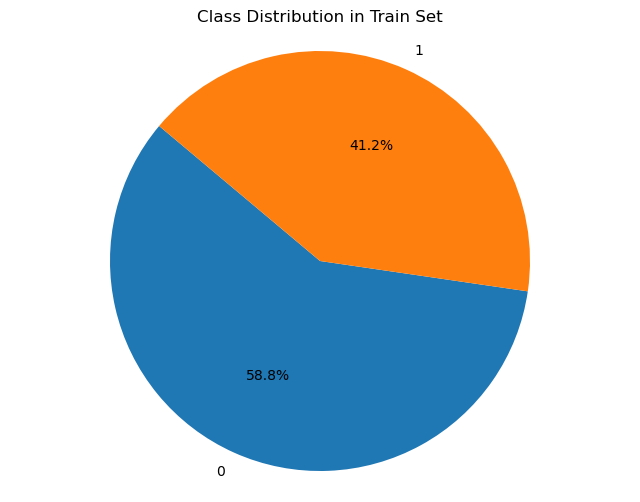

In [17]:
class_counts = train_df['paired'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Train Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

In [18]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22805 entries, 106028 to 43212
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AA_Sequence  22805 non-null  object
 1   heavy_chain  22805 non-null  object
 2   light_chain  22805 non-null  object
 3   paired       22805 non-null  int64 
 4   strategy     20553 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


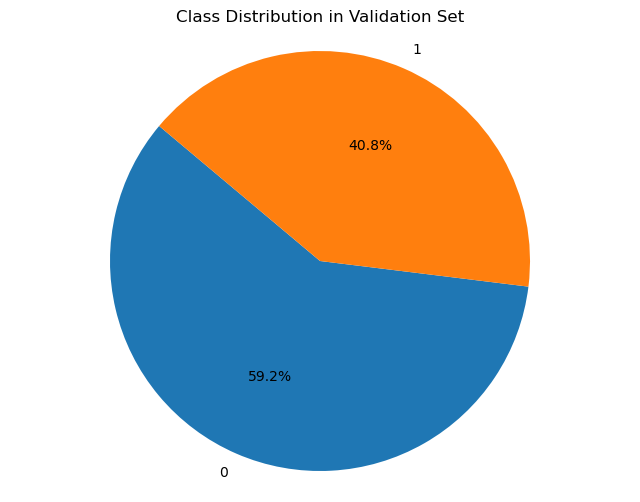

In [19]:
class_counts = val_df['paired'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Validation Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22806 entries, 207154 to 127487
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AA_Sequence  22806 non-null  object
 1   heavy_chain  22806 non-null  object
 2   light_chain  22806 non-null  object
 3   paired       22806 non-null  int64 
 4   strategy     20522 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


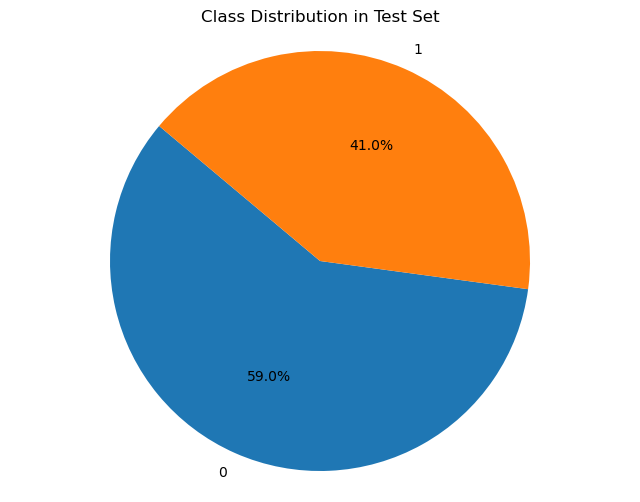

In [21]:
class_counts = test_df['paired'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Test Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

### Export dataset


In [22]:
train_df.to_csv('train_agg_new.csv', index=False)
val_df.to_csv('val_agg_new.csv', index=False)
test_df.to_csv('test_agg_new.csv', index=False)